In [2]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [3]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [4]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [13]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [14]:
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [15]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

In [16]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 4s 79ms/step - loss: 0.0096 - val_loss: 8.1684e-04
Epoch 2/100
21/21 [==============================] - 1s 53ms/step - loss: 9.8693e-04 - val_loss: 2.4912e-04
Epoch 3/100
21/21 [==============================] - 1s 53ms/step - loss: 5.4427e-04 - val_loss: 1.5608e-04
Epoch 4/100
21/21 [==============================] - 1s 53ms/step - loss: 4.5689e-04 - val_loss: 1.9503e-04
Epoch 5/100
21/21 [==============================] - 1s 52ms/step - loss: 4.4077e-04 - val_loss: 1.2623e-04
Epoch 6/100
21/21 [==============================] - 2s 87ms/step - loss: 4.0275e-04 - val_loss: 1.1617e-04
Epoch 7/100
21/21 [==============================] - 2s 86ms/step - loss: 3.7952e-04 - val_loss: 1.0131e-04
Epoch 8/100
21/21 [==============================] - 2s 88ms/step - loss: 3.6703e-04 - val_loss: 1.0432e-04
Epoch 9/100
21/21 [==============================] - 1s 53ms/step - loss: 3.6695e-04 - val_loss: 9.8887e-05
Epoch 10/100
21/21 [============

In [19]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [20]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [21]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 27014.37912222419


In [22]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9991640567092
Testing MAE: 26840.7695927686


In [23]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.2309051901102066], [0.2310767024755478], [0.23128469288349152], [0.23151329159736633], [0.23175880312919617], [0.23201815783977509], [0.23228910565376282], [0.2325698882341385], [0.23285934329032898], [0.23315653204917908], [0.23346073925495148], [0.23377153277397156], [0.23408854007720947], [0.23441152274608612], [0.2347402572631836], [0.23507459461688995], [0.2354145050048828], [0.235759899020195], [0.23611076176166534], [0.2364671677350998], [0.23682904243469238], [0.23719647526741028], [0.2375694364309311], [0.23794808983802795], [0.2383323758840561], [0.23872238397598267], [0.239118292927742], [0.2395200878381729], [0.23992779850959778], [0.24034158885478973], [0.24076147377490997], [0.24118754267692566], [0.24161989986896515], [0.2420586347579956], [0.24250386655330658], [0.24295561015605927], [0.2434140294790268], [0.24387915432453156], [0.2443510740995407], [0.244829922914505], [0.2453157752752304], [0.2458087056875229], [0.24630889296531677], [0.24681630730628967], [0.2473

In [24]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27743.84684953],
       [27759.5582226 ],
       [27778.61116312],
       [27799.55192545],
       [27822.04198477],
       [27845.8001471 ],
       [27870.6202945 ],
       [27896.3413547 ],
       [27922.85685618],
       [27950.08080271],
       [27977.94767338],
       [28006.41788261],
       [28035.45730492],
       [28065.0441    ],
       [28095.15779257],
       [28125.78473242],
       [28156.92218952],
       [28188.56197376],
       [28220.7027201 ],
       [28253.35125366],
       [28286.50074933],
       [28320.15939722],
       [28354.32446731],
       [28389.0109748 ],
       [28424.21345962],
       [28459.94011188],
       [28496.20731182],
       [28533.01369441],
       [28570.36198969],
       [28608.26721288],
       [28646.730729  ],
       [28685.76072817],
       [28725.36676551],
       [28765.55703114],
       [28806.34244523],
       [28847.72437278],
       [28889.71782902],
       [28932.32554398],
       [28975.55570778],
       [29019.42060559],


In [25]:
# # Append the last 100 values of test_data to the beginning of y_pred
# last_100_test_data = scaler.inverse_transform(test_data[:101])
# y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [26]:
# print(y_pred_with_test_data.shape)
# test_data.shape

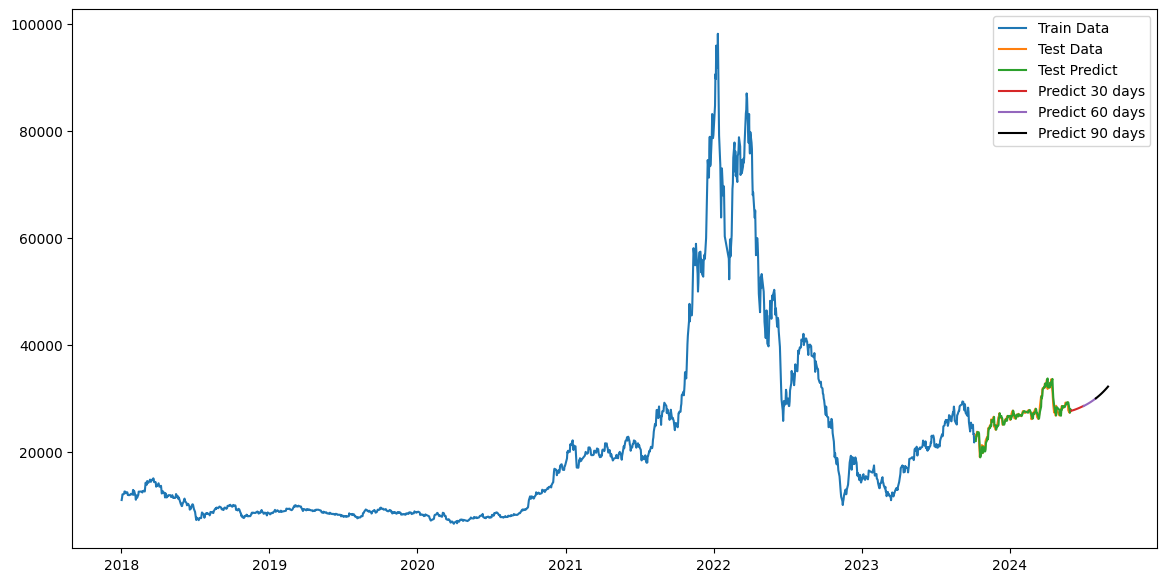

In [27]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()